In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix

In [2]:
data=pd.read_csv('./Data/clean_data.csv')
data.drop(data.columns[[0]],axis=1,inplace=True)

In [3]:
def Range(a):
    return a.max()-a.min();

In [4]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap='YlOrRd'):
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(20,10),)
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [5]:
range_sample=data.groupby(['Activity','Subject','Sample_Num']).apply(Range).add_prefix('range_')
stdev_sample=data.groupby(['Activity','Subject','Sample_Num']).std().add_prefix('std_')
mean_sample=data.groupby(['Activity','Subject','Sample_Num']).mean().add_prefix('mean_')

In [6]:
total_data=pd.concat([stdev_sample,mean_sample,range_sample],axis=1)
total_data.reset_index(inplace=True)
total_data['Class']=total_data.Activity.replace({'sitting':'Light','standing':'Light','lying':'Light','walking':'Moderate','climbingup':'Moderate','climbingdown':'Moderate','jumping':'Vigorous','running':'Vigorous'})

In [7]:
columns=[
       'std_attr_x_gyro', 'std_attr_y_gyro', 'std_attr_z_gyro',
         'std_attr_x_acc', 'std_attr_y_acc', 'std_attr_z_acc', 
         'mean_attr_x_gyro', 'mean_attr_y_gyro', 'mean_attr_z_gyro', 
         'mean_attr_x_acc', 'mean_attr_y_acc', 'mean_attr_z_acc',
         'range_attr_x_gyro', 'range_attr_y_gyro','range_attr_z_gyro', 
         'range_attr_x_acc', 'range_attr_y_acc', 'range_attr_z_acc']

In [8]:
train_temp=total_data.Subject<=3
validate_temp=total_data.Subject==4
X_train=total_data[columns][train_temp]
X_validate=total_data[columns][validate_temp]
Y_train=total_data.Class[train_temp]
Y_validate=total_data.Class[validate_temp]
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_validate=scaler.fit_transform(X_validate)

In [9]:
print(X_train.shape)
print(X_validate.shape)

(6386, 18)
(2211, 18)


In [10]:
def implement_model(model,title):
    model.fit(X_train,Y_train)
    Y_predicted_train=model.predict(X_train)
    Y_predicted_validate=model.predict(X_validate)
    print(f'Training F1 score is: {f1_score(Y_train,Y_predicted_train,average="macro"):.3f}')
    print(f'Validation F1 score is: {f1_score(Y_validate,Y_predicted_validate,average="macro"):.3f}')
    print(f'Training Accuracy is: {accuracy_score(Y_train,Y_predicted_train):.3f}')
    print(f'Validation Accuracy is: {accuracy_score(Y_validate,Y_predicted_validate):.3f}')
    np.set_printoptions(precision=2)
    cm=confusion_matrix(Y_validate,Y_predicted_validate)
    plt.figure()
    plot_confusion_matrix(cm,classes=['Light','Moderate','Vigorous'],title='Validation Confusion Matrix for '+title);

Training F1 score is: 0.996
Validation F1 score is: 0.846
Training Accuracy is: 0.997
Validation Accuracy is: 0.906


<Figure size 432x288 with 0 Axes>

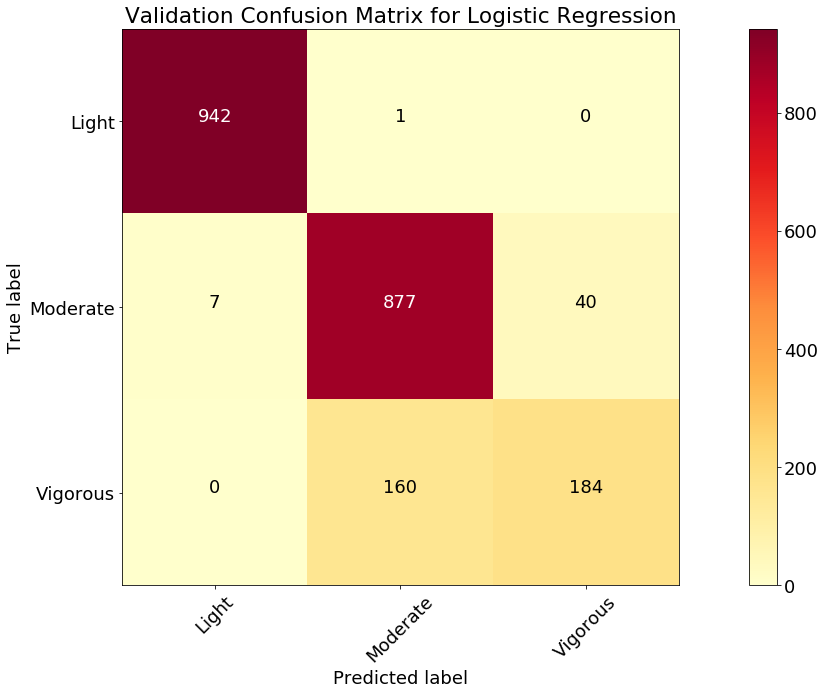

In [11]:
classifier_1=LogisticRegression(solver='newton-cg',multi_class='multinomial',max_iter=500)
implement_model(classifier_1,title='Logistic Regression')

Training F1 score is: 0.998
Validation F1 score is: 0.806
Training Accuracy is: 0.998
Validation Accuracy is: 0.883


<Figure size 432x288 with 0 Axes>

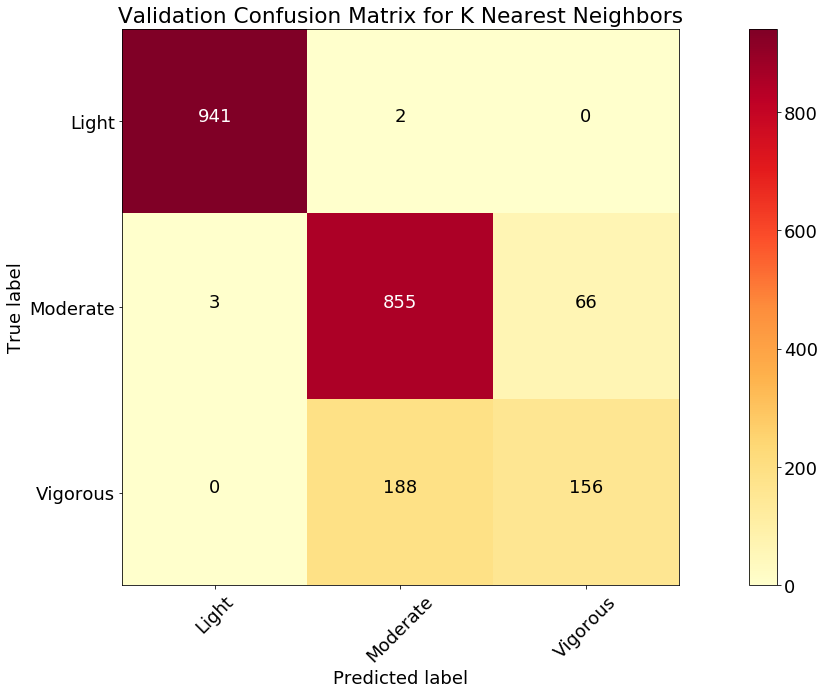

In [12]:
classifier_2=KNeighborsClassifier(n_neighbors=3)
implement_model(classifier_2,title='K Nearest Neighbors')

Training F1 score is: 0.989
Validation F1 score is: 0.854
Training Accuracy is: 0.992
Validation Accuracy is: 0.911


<Figure size 432x288 with 0 Axes>

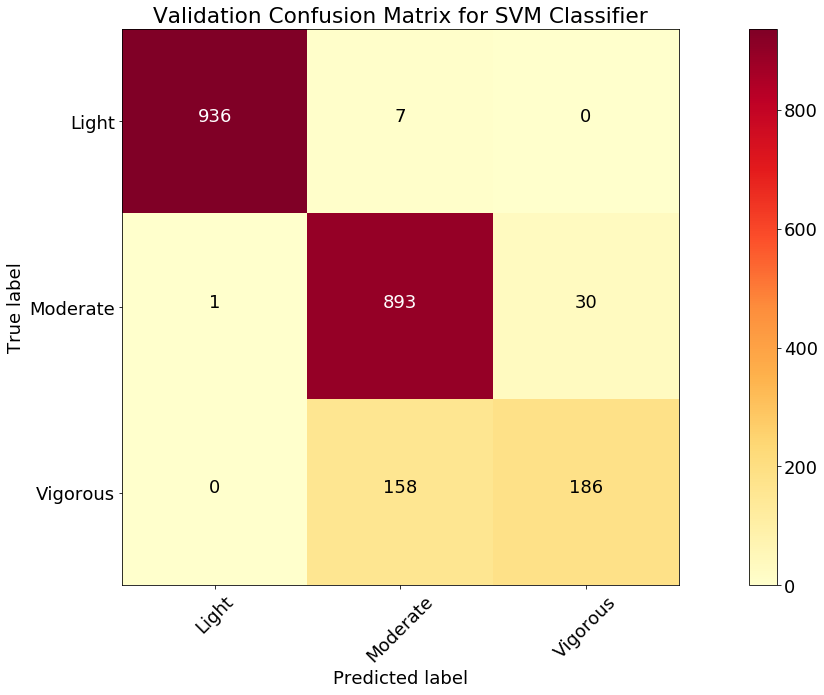

In [13]:
classifier_3=svm.SVC(kernel='poly',gamma='scale',C=1.0)
implement_model(classifier_3,title='SVM Classifier')

In [14]:
# Fitting logistic regression model to all 4 training subjects for use on final 2 test subjects

In [15]:
mask=total_data.Subject<=4
X_final=total_data[columns][mask]
Y_final=total_data.Class[mask]
classifier=LogisticRegression(solver='newton-cg',multi_class='multinomial',max_iter=500)
classifier.fit(X_final,Y_final)
Y_predicted=classifier.predict(X_final)
print(f'Training F1 score is: {f1_score(Y_final,Y_predicted,average="macro"):.3f}')
print(f'Training accuracy is: {accuracy_score(Y_final,Y_predicted):.3f}')

Training F1 score is: 0.989
Training accuracy is: 0.992


In [16]:
# Saving model for later use

In [17]:
pkl_file="./Data/Logistic_Regression_Model.pkl"
with open(pkl_file,'wb') as file:
    pickle.dump(classifier,file)